## 1-5. 選取重要特徵

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

df = pd.read_csv('ex1.csv')

imp = SimpleImputer(missing_values=np.nan, 
                    strategy='median')
x = df['HP'].values.reshape(-1, 1)
df['HP'] = imp.fit_transform(x)
df.tail(3)

,Number,Name,Type1,Type2,HP,Attack,Defense,SpecialAtk,SpecialDef,Speed,Generation,Legendary
165,151,夢幻,Psychic,NaN,100.0,100,100,100,100,100,1,False
166,153,月桂葉,Grass,NaN,62.0,62,80,63,80,60,2,False
167,166,安瓢蟲,Bug,Flying,62.0,35,50,55,110,85,2,False


In [2]:
from sklearn.feature_selection import VarianceThreshold
# 產生選取器
selector = VarianceThreshold(threshold=700)
X = df.loc[:, 'HP':'Speed']
# 看每個特徵的變異性
print(selector.fit(X).variances_)
# 丟棄低變異特徵(這裡只有 SpecialDef 被丟棄)
selector.fit_transform(X)[:3]

[ 778.66312358  939.8423682   808.76016865 1166.99603175  649.47785573
  866.7906746 ]


array([[ 45.,  49.,  49.,  65.,  45.],
       [ 60.,  62.,  63.,  80.,  60.],
       [ 80.,  82.,  83., 100.,  80.]])

In [3]:
# 轉換 Legendary 特徵：True->1、False->0
df['Legendary'] = [1 if x else 0 for x in df.Legendary]
# 新增 hasType2 特徵: 有 Type2->1、無 Type2->0
df['hasType2'] = [0 if x is np.nan else 1 for x in df.Type2]

p = 0.6
selector = VarianceThreshold(threshold=p*(1-p))
print('門檻值 =', p*(1-p))
X = df.loc[:, 'Generation':'hasType2'].values
# 只有 hasType2 特徵會被保留下來
selector.fit(X).variances_

門檻值 = 0.24


array([0.01176304, 0.03443878, 0.24911423])

In [4]:
X = df.loc[:, 'HP':'Speed'] 
# 產生相關矩陣
corr_matrix = X.corr().abs()
corr_matrix

,HP,Attack,Defense,SpecialAtk,SpecialDef,Speed
HP,1.000000,0.352144,0.175534,0.264278,0.504488,0.020288
Attack,0.352144,1.000000,0.477838,0.214138,0.431734,0.320103
Defense,0.175534,0.477838,1.000000,0.262892,0.217897,0.026088
SpecialAtk,0.264278,0.214138,0.262892,1.000000,0.546631,0.453567
SpecialDef,0.504488,0.431734,0.217897,0.546631,1.000000,0.445071
Speed,0.020288,0.320103,0.026088,0.453567,0.445071,1.000000


In [5]:
# 產生矩陣上三角的遮罩
mask = np.ones(corr_matrix.shape).astype(bool)
mask = np.triu(mask, k=1)
# 選取相關矩陣的上三角
upper = corr_matrix.where(mask)
upper

,HP,Attack,Defense,SpecialAtk,SpecialDef,Speed
HP,NaN,0.352144,0.175534,0.264278,0.504488,0.020288
Attack,NaN,NaN,0.477838,0.214138,0.431734,0.320103
Defense,NaN,NaN,NaN,0.262892,0.217897,0.026088
SpecialAtk,NaN,NaN,NaN,NaN,0.546631,0.453567
SpecialDef,NaN,NaN,NaN,NaN,NaN,0.445071
Speed,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# 刪除相關係數 > 0.47 的特徵('Defense', 'SpecialDef')
to_drop = [c for c in upper if any(upper[c] > 0.47)]
df.drop(df[to_drop], axis=1).head(3)

,Number,Name,Type1,Type2,HP,Attack,SpecialAtk,Speed,Generation,Legendary,hasType2
0,1,妙蛙種子,Grass,Poison,45.0,49,65,45,1,0,1
1,2,妙蛙草,Grass,Poison,60.0,62,80,60,1,0,1
2,3,妙蛙花,Grass,Poison,80.0,82,100,80,1,0,1


In [7]:
from scipy import stats
# 點二列相關(point-biserial correlation)，用以衡量連續變數與二元類別變數的相關性
print(stats.pointbiserialr(df['HP'], df['hasType2']))
# 皮爾森相關係數 => 兩個結果相同
df.loc[:, ['HP','hasType2']].corr()

PointbiserialrResult(correlation=0.08285622146815766, pvalue=0.2856294970000373)


,HP,hasType2
HP,1.000000,0.082856
hasType2,0.082856,1.000000


In [8]:
# 產生斯皮爾曼相關矩陣
corr_matrix = X.corr(method='spearman')
corr_matrix

,HP,Attack,Defense,SpecialAtk,SpecialDef,Speed
HP,1.000000,0.564247,0.419371,0.389530,0.583880,0.112199
Attack,0.564247,1.000000,0.550218,0.196540,0.424258,0.293070
Defense,0.419371,0.550218,1.000000,0.321829,0.299292,0.016637
SpecialAtk,0.389530,0.196540,0.321829,1.000000,0.572246,0.402310
SpecialDef,0.583880,0.424258,0.299292,0.572246,1.000000,0.454588
Speed,0.112199,0.293070,0.016637,0.402310,0.454588,1.000000


In [9]:
# 計算斯皮爾曼相關係數與 p值
stats.spearmanr(df['HP'], df['Attack'])

SpearmanrResult(correlation=0.5642473841533602, pvalue=1.6544873304447606e-15)

In [10]:
# 計算肯德爾相關係數與 p值
print(stats.kendalltau(df['HP'], df['Attack']))
# 產生肯德爾相關矩陣
corr_matrix = X.corr(method='kendall')
corr_matrix

KendalltauResult(correlation=0.41534787560519015, pvalue=1.2538513443744389e-14)


,HP,Attack,Defense,SpecialAtk,SpecialDef,Speed
HP,1.000000,0.415348,0.322465,0.281925,0.441446,0.076019
Attack,0.415348,1.000000,0.399782,0.136697,0.307479,0.203907
Defense,0.322465,0.399782,1.000000,0.239553,0.235209,0.006498
SpecialAtk,0.281925,0.136697,0.239553,1.000000,0.444924,0.293127
SpecialDef,0.441446,0.307479,0.235209,0.444924,1.000000,0.318700
Speed,0.076019,0.203907,0.006498,0.293127,0.318700,1.000000


In [11]:
col = [df.columns[-1]] + list(df.columns[4:-1])
X = df.loc[:, col]
corr_matrix = X.corr(method='kendall')
corr_matrix

,hasType2,HP,Attack,Defense,SpecialAtk,SpecialDef,Speed,Generation,Legendary
hasType2,1.000000,0.125690,0.087135,0.145104,0.167511,0.057040,-0.019050,0.006545,0.075740
HP,0.125690,1.000000,0.415348,0.322465,0.281925,0.441446,0.076019,0.000000,0.223976
Attack,0.087135,0.415348,1.000000,0.399782,0.136697,0.307479,0.203907,-0.094959,0.184349
Defense,0.145104,0.322465,0.399782,1.000000,0.239553,0.235209,0.006498,-0.012270,0.143693
SpecialAtk,0.167511,0.281925,0.136697,0.239553,1.000000,0.444924,0.293127,-0.026957,0.235489
SpecialDef,0.057040,0.441446,0.307479,0.235209,0.444924,1.000000,0.318700,0.093204,0.198988
Speed,-0.019050,0.076019,0.203907,0.006498,0.293127,0.318700,1.000000,0.005656,0.193095
Generation,0.006545,0.000000,-0.094959,-0.012270,-0.026957,0.093204,0.005656,1.000000,-0.021124
Legendary,0.075740,0.223976,0.184349,0.143693,0.235489,0.198988,0.193095,-0.021124,1.000000


In [12]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# 將數值特徵離散化
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_bin = est.fit_transform(df.loc[:, 'HP':'Speed'])

X = df.loc[:, 'HP':'Generation']
X.loc[:, 'HP':'Speed'] = X_bin
y = df['hasType2']
# 選取 k=2 個卡方統計量最高的特徵
selector = SelectKBest(chi2, k=2)
X_kbest = selector.fit_transform(X, y)

print(X_kbest[:4,:])  # 選出 Defense 與 SpecialAtk
print(chi2(X, y))     # 輸出卡方統計量與 p值
X.head(4)

[[2. 2.]
 [3. 3.]
 [4. 4.]
 [6. 5.]]
(array([1.24269663e+00, 1.91258104e+00, 4.71224147e+00, 7.98876404e+00,
       1.19673045e+00, 8.19822675e-02, 8.36631054e-05]), array([0.26495198, 0.16667683, 0.02994858, 0.00470685, 0.27397614,
       0.77462886, 0.99270205]))


,HP,Attack,Defense,SpecialAtk,SpecialDef,Speed,Generation
0,1.0,2.0,2.0,2.0,4.0,2.0,1
1,2.0,3.0,3.0,3.0,5.0,3.0,1
2,2.0,4.0,4.0,4.0,7.0,4.0,1
3,2.0,5.0,6.0,5.0,9.0,4.0,1


In [13]:
from sklearn.feature_selection import SelectPercentile, f_classif

X = df.loc[:, 'HP':'Speed']
y = df['hasType2']
# 選取前 50% F值最高的特徵
selector = SelectPercentile(f_classif, percentile=50)
X_pbest = selector.fit_transform(X, y)

print(X_pbest[:4,:])   # 選出 Attack, Defense, SpecialDef
print(f_classif(X, y)) # 輸出 F值與 p值
X.head(4)

[[ 49.  49.  65.]
 [ 62.  63.  80.]
 [ 82.  83. 100.]
 [100. 123. 122.]]
(array([1.14749319, 2.97372848, 6.84241862, 5.48589059, 0.7838129 ,
       0.14165011]), array([0.2856295 , 0.08648805, 0.00972243, 0.02035716, 0.37725819,
       0.70712666]))


,HP,Attack,Defense,SpecialAtk,SpecialDef,Speed
0,45.0,49,49,65,65,45
1,60.0,62,63,80,80,60
2,80.0,82,83,100,100,80
3,80.0,100,123,122,120,80


In [14]:
from sklearn.feature_selection import mutual_info_classif

selector = SelectPercentile(mutual_info_classif, 
                            percentile=50)
X_pbest = selector.fit_transform(X, y)
print(X_pbest[:4,:])   # 選出 Attack, SpecialAtk, SpecialDef
print(mutual_info_classif(X, y)) # 輸出 MI值

[[ 49.  65.  65.]
 [ 62.  80.  80.]
 [ 82. 100. 100.]
 [100. 122. 120.]]
[0.         0.03685285 0.         0.07544646 0.01753647 0.        ]


In [15]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

X = df.loc[:, 'HP':'Speed'] 
y = df['hasType2']
# 以邏輯斯迴歸預測是否有雙屬性
model = LogisticRegression()
selector = RFECV(model, step=1, cv=5, scoring='accuracy')
selector = selector.fit(X, y)

print('最佳特徵數：', selector.n_features_)
print('哪些類型最佳：', selector.support_)
print('特徵排名(1最好)：', selector.ranking_)
X.columns[selector.support_]

最佳特徵數： 5
哪些類型最佳： [False  True  True  True  True  True]
特徵排名(1最好)： [2 1 1 1 1 1]


Index(['Attack', 'Defense', 'SpecialAtk', 'SpecialDef', 'Speed'], dtype='object')

In [16]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
plt.style.use('fivethirtyeight')

# 利用 kNN 預測 HP
X, y = df.loc[:, 'Attack':'hasType2'], df['HP']
model = KNeighborsRegressor()
model.fit(X, y)

selector = permutation_importance(model, X, y, n_repeats=10,
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1)

importance = selector.importances_mean
std = selector.importances_std
# 按特徵重要性排序
idx = np.argsort(importance)[::-1]
print("特徵重要性排序：")
for c in range(X.shape[1]):
    print('%d. %s' % (c+1, X.columns[idx[c]]), end='')
    print('\t (feature %d: %f)' % (idx[c], 
                                   importance[idx[c]]))


Bad key "text.kerning_factor" on line 4 in
C:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


特徵重要性排序：
1. Attack	 (feature 0: 184.058952)
2. SpecialDef	 (feature 3: 158.866690)
3. Speed	 (feature 4: 113.976619)
4. Defense	 (feature 1: 105.848571)
5. SpecialAtk	 (feature 2: 95.775810)
6. hasType2	 (feature 7: 0.535714)
7. Legendary	 (feature 6: 0.000000)
8. Generation	 (feature 5: 0.000000)


(-1, 8)

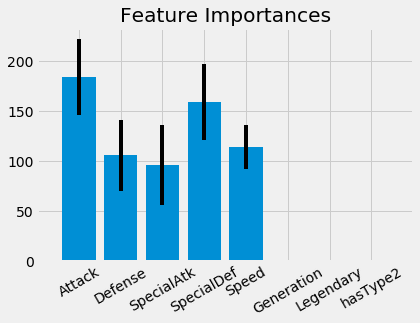

In [17]:
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importance, yerr=std)
plt.xticks(range(X.shape[1]), X.columns, rotation=30)
plt.xlim([-1, X.shape[1]])

In [18]:
from sklearn.neighbors import KNeighborsClassifier
# 利用 kNN 預測 hasType2
X, y = df.loc[:, 'HP':'Legendary'], df['hasType2']
model = KNeighborsClassifier().fit(X, y)

selector = permutation_importance(model, X, y, n_repeats=10,
                                  scoring='accuracy', 
                                  n_jobs=-1)

importance = selector.importances_mean
std = selector.importances_std
# 按特徵重要性排序
idx = np.argsort(importance)[::-1]
print("特徵重要性排序：")
for c in range(X.shape[1]):
    print('%d. %s' % (c+1, X.columns[idx[c]]), end='')
    print('\t (feature %d: %f)' % (idx[c], 
                                   importance[idx[c]]))

特徵重要性排序：
1. SpecialAtk	 (feature 3: 0.073810)
2. Speed	 (feature 5: 0.061310)
3. Defense	 (feature 2: 0.057738)
4. Attack	 (feature 1: 0.039881)
5. HP	 (feature 0: 0.036905)
6. SpecialDef	 (feature 4: 0.017857)
7. Legendary	 (feature 7: 0.000000)
8. Generation	 (feature 6: 0.000000)


(-1, 8)

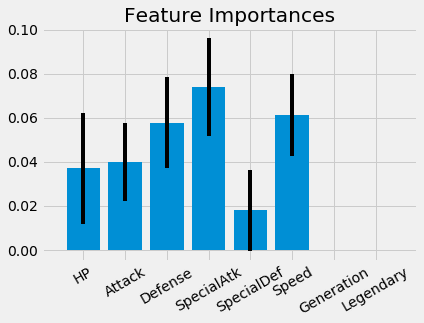

In [19]:
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importance, yerr=std)
plt.xticks(range(X.shape[1]), X.columns, rotation=30)
plt.xlim([-1, X.shape[1]])

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
# 利用 kNN 預測 hasType2
X, y = df.loc[:, 'HP':'Legendary'], df['hasType2']
X_std = StandardScaler().fit_transform(X)
# 先將特徵標準化，得到的結果比較穩定
model = KNeighborsClassifier().fit(X_std, y)
selector = permutation_importance(model, X_std, y, 
                                  n_repeats=10,
                                  scoring='accuracy', 
                                  n_jobs=-1)

importance = selector.importances_mean
std = selector.importances_std
# 按特徵重要性排序
idx = np.argsort(importance)[::-1]
print("特徵重要性排序：")
for c in range(X.shape[1]):
    print('%d. %s' % (c+1, X.columns[idx[c]]), end='')
    print('\t (feature %d: %f)' % (idx[c], 
                                   importance[idx[c]]))

特徵重要性排序：
1. Speed	 (feature 5: 0.085119)
2. Defense	 (feature 2: 0.073214)
3. Attack	 (feature 1: 0.058333)
4. SpecialAtk	 (feature 3: 0.050000)
5. HP	 (feature 0: 0.048214)
6. SpecialDef	 (feature 4: 0.039881)
7. Legendary	 (feature 7: 0.023810)
8. Generation	 (feature 6: -0.006548)


(-1, 8)

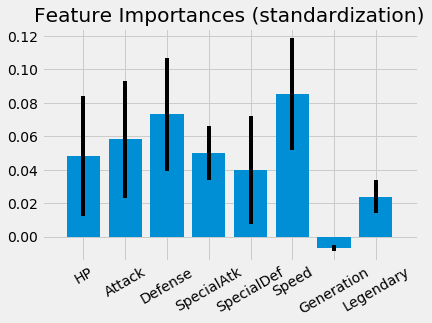

In [21]:
plt.title("Feature Importances (standardization)")
plt.bar(range(X.shape[1]), importance, yerr=std)
plt.xticks(range(X.shape[1]), X.columns, rotation=30)
plt.xlim([-1, X.shape[1]])